Using device: cpu
10.79M parameters
--- Found pre-trained model 'model.pth'. Loading model. ---
--- Model loaded. Generating sample text to verify. ---
Generated sample:

 Wrw, we should fall of disprobat Angelo:
For st the keepy of this lords, as the honesty
That the re
--------------------

--- Assembling Input Sequences from input.txt ---
  Assembled 50000 input sequences from the start of the file.

--- Creating True Input Distribution from Data Embeddings ---
  Performing embedding forward pass on 50000 sequences of length 256...
  Calculating mean and covariance from 50000 embedding vectors...
--- Input Distribution Created. ---

--- Model grouped into 7 sequential blocks for propagation. ---

--- Computing Ground Truth Output Distribution (High-Density Sampling) ---
  [Ground Truth] Propagating through layer group 1/7...
  [Ground Truth] Propagating through layer group 2/7...
  [Ground Truth] Propagating through layer group 3/7...
  [Ground Truth] Propagating through layer group

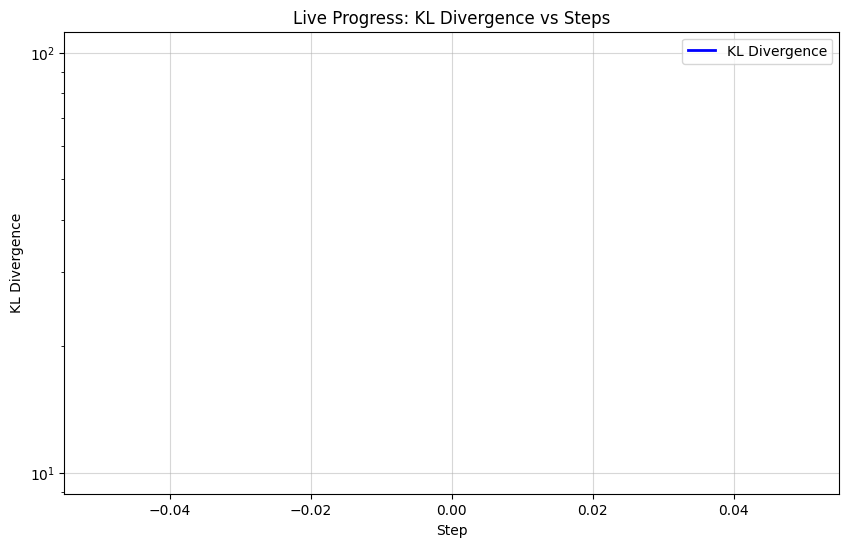

  [Simulation] Step 2/4433: 0.31% filled, KL Div = 18.1712, MSE = 0.0836, Cov. Ratio = 0.2784
  [Simulation] Step 3/4433: 0.33% filled, KL Div = 15.6331, MSE = 0.1113, Cov. Ratio = 0.3074
  [Simulation] Step 4/4433: 0.36% filled, KL Div = 14.7198, MSE = 0.1237, Cov. Ratio = 0.3198
  [Simulation] Step 5/4433: 0.38% filled, KL Div = 14.8875, MSE = 0.1168, Cov. Ratio = 0.3304
  [Simulation] Step 6/4433: 0.40% filled, KL Div = 14.4271, MSE = 0.1112, Cov. Ratio = 0.3464
    └── Saved plot for step 6
  [Simulation] Step 7/4433: 0.42% filled, KL Div = 15.0618, MSE = 0.0835, Cov. Ratio = 0.3301
  [Simulation] Step 8/4433: 0.45% filled, KL Div = 12.8920, MSE = 0.0995, Cov. Ratio = 0.3811
  [Simulation] Step 9/4433: 0.47% filled, KL Div = 14.4616, MSE = 0.1136, Cov. Ratio = 0.3647
  [Simulation] Step 10/4433: 0.49% filled, KL Div = 13.7173, MSE = 0.0938, Cov. Ratio = 0.3833
  [Simulation] Step 11/4433: 0.51% filled, KL Div = 13.5530, MSE = 0.0741, Cov. Ratio = 0.3836
    └── Saved plot for step 

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch.distributions import MultivariateNormal

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)
# Create a dummy input.txt if it doesn't exist
try:
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
except FileNotFoundError:
    print("Warning: 'input.txt' not found. Using dummy text.")
    text = "hello world. this is a test of the gpt model. we will see how well it can learn to generate text."
    with open('input.txt', 'w', encoding='utf-8') as f:
        f.write(text)


# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Create output directory for visualizations
os.makedirs('training_visualizations', exist_ok=True)

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(f"{sum(p.numel() for p in m.parameters())/1e6:.2f}M parameters")

# Check if a pre-trained model exists
if not os.path.exists('model.pth'):
    print("\n--- Training New Model ---")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    # save the trained model
    print("Training complete. Saving model to 'model.pth'.")
    torch.save(model.state_dict(), 'model.pth')
else:
    print("--- Found pre-trained model 'model.pth'. Loading model. ---")
    model.load_state_dict(torch.load('model.pth', map_location=device))
    m = model.to(device)
    print("--- Model loaded. Generating sample text to verify. ---")
    with torch.no_grad():
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_output = m.generate(context, max_new_tokens=100)[0].tolist()
        print("Generated sample:")
        print(decode(generated_output))
        print("-" * 20)


class FactorGaussian:
    def __init__(self, mean, L_factor, diagonal):
        """Σ = L @ L.T + diag(diagonal)"""
        self.mean = mean
        self.L = L_factor
        self.diagonal = diagonal

    def covariance(self):
        stable_diagonal = self.diagonal + 1e-8
        return self.L @ self.L.T + torch.diag(stable_diagonal)

    def get_diagonal(self):
        l_diag = torch.sum(self.L * self.L, dim=1)
        return l_diag + self.diagonal

def propagate_by_sampling(input_distribution, layer_block, mask=None, num_samples=1000):
    input_mean = input_distribution.mean
    input_cov = input_distribution.covariance()
    input_dim = input_mean.shape[0]

    epsilon = 1e-6 * torch.eye(input_dim, device=input_mean.device)
    input_dist_sampler = MultivariateNormal(loc=input_mean, covariance_matrix=input_cov + epsilon)
    samples = input_dist_sampler.sample(torch.Size([num_samples]))

    samples_reshaped = samples.unsqueeze(1)

    with torch.no_grad():
        output_samples_reshaped = layer_block(samples_reshaped.to(device))

    output_samples = output_samples_reshaped.squeeze(1)

    output_mean = torch.mean(output_samples, dim=0)
    mean_subtracted_output = output_samples - output_mean
    full_output_covariance = (1 / (num_samples - 1)) * mean_subtracted_output.T @ mean_subtracted_output
    output_dim = output_mean.shape[0]

    if mask is not None and len(mask) > 0:
        masked_cov = torch.zeros_like(full_output_covariance)
        valid_mask_entries = [(r, c) for r, c in mask if r < output_dim and c < output_dim]
        for r, c in valid_mask_entries:
            masked_cov[r, c] = full_output_covariance[r, c]
            if r != c:
                masked_cov[c, r] = full_output_covariance[c, r]
    else:
        masked_cov = torch.diag(torch.diag(full_output_covariance))

    output_diag_variances = torch.diag(full_output_covariance)
    off_diag_cov = masked_cov - torch.diag(torch.diag(masked_cov))

    try:
        eigvals, eigvecs = torch.linalg.eigh(off_diag_cov)
        eigvals_positive = torch.clamp(eigvals, min=0)
        sqrt_eigvals = torch.sqrt(eigvals_positive)
        tol = 1e-6
        rank = torch.sum(eigvals_positive > tol)
        output_L = eigvecs[:, -rank:] @ torch.diag(sqrt_eigvals[-rank:])
        l_diag_contribution = torch.sum(output_L * output_L, dim=1)
        output_diag_remainder = torch.clamp(output_diag_variances - l_diag_contribution, min=0)
    except torch.linalg.LinAlgError:
        output_L = torch.zeros((output_dim, 1), device=output_mean.device)
        output_diag_remainder = output_diag_variances

    return FactorGaussian(mean=output_mean, L_factor=output_L, diagonal=output_diag_remainder)


def compute_estimator_kl_div(true_output_distribution, predicted_output_distribution):
    mu_true, mu_pred = true_output_distribution.mean, predicted_output_distribution.mean
    sigma_true = true_output_distribution.covariance().detach().cpu().numpy()
    sigma_pred = predicted_output_distribution.covariance().detach().cpu().numpy()
    mu_true, mu_pred = mu_true.detach().cpu().numpy(), mu_pred.detach().cpu().numpy()

    epsilon = 1e-6 * np.eye(sigma_true.shape[0])
    sigma_true_stable, sigma_pred_stable = sigma_true + epsilon, sigma_pred + epsilon

    mu_diff = mu_pred - mu_true
    k = len(mu_true)
    try:
        sigma_pred_inv = np.linalg.inv(sigma_pred_stable)
        trace_term = np.trace(sigma_pred_inv @ sigma_true_stable)
        quad_term = mu_diff.T @ sigma_pred_inv @ mu_diff
        sign_true, logdet_true = np.linalg.slogdet(sigma_true_stable)
        sign_pred, logdet_pred = np.linalg.slogdet(sigma_pred_stable)
        if sign_true <= 0 or sign_pred <= 0: return float('inf')
        log_det_term = logdet_pred - logdet_true
        return 0.5 * (trace_term + quad_term - k + log_det_term)
    except np.linalg.LinAlgError:
        return float('inf')

def compute_estimator_mse(true_output_distribution, predicted_output_distribution):
    true_mean = true_output_distribution.mean
    predicted_mean = predicted_output_distribution.mean
    mse = torch.mean((true_mean - predicted_mean) ** 2)
    return mse.item()

def find_true_distribution_by_sampling(input_distribution, grouped_layers, num_samples=50000):
    print("\n--- Computing Ground Truth Output Distribution (High-Density Sampling) ---")
    current_distribution = input_distribution
    for i, layer_block in enumerate(grouped_layers):
        print(f"  [Ground Truth] Propagating through layer group {i+1}/{len(grouped_layers)}...")
        output_dim = get_output_dim_from_block(layer_block)
        full_mask = set((r, c) for r in range(output_dim) for c in range(output_dim))
        current_distribution = propagate_by_sampling(current_distribution, layer_block, mask=full_mask, num_samples=num_samples)
    print("--- Ground Truth Calculation Complete. ---")
    return current_distribution

def calculate_range_exceedance_probability(distribution, lower_bound=-5, upper_bound=5):
    mu = distribution.mean[0].item()
    variance = distribution.get_diagonal()[0].item()
    sigma = np.sqrt(max(variance, 1e-9))
    prob_below = norm.cdf(lower_bound, loc=mu, scale=sigma)
    prob_above = 1 - norm.cdf(upper_bound, loc=mu, scale=sigma)
    return prob_below + prob_above

def calculate_covariance_tracking_ratio(true_distribution, estimated_distribution):
    true_cov = true_distribution.covariance().detach().cpu().numpy()
    est_cov = estimated_distribution.covariance().detach().cpu().numpy()

    true_norm = np.linalg.norm(true_cov, 'fro')
    est_norm = np.linalg.norm(est_cov, 'fro')

    if true_norm == 0:
        return 1.0 if est_norm == 0 else 0.0
    return min(est_norm / true_norm, 1.0)

def calculate_total_mask_entries(masks):
    return sum(len(mask) for mask in masks)

def calculate_total_possible_entries(grouped_layers):
    total = 0
    for block in grouped_layers:
        output_dim = get_output_dim_from_block(block)
        total += output_dim * output_dim
    return total

def get_output_dim_from_block(layer_block):
    if isinstance(layer_block, Block):
        return n_embd
    elif isinstance(layer_block, nn.Sequential):
        for layer in reversed(list(layer_block.modules())):
            if isinstance(layer, nn.Linear):
                return layer.out_features
    raise TypeError(f"Unknown layer block type: {type(layer_block)}")

def create_guessing_ordering(input_distribution, model, num_samples=20000):
    """
    Creates a heuristic ordering of covariance entries based on their strength
    observed from a single, high-sample forward pass.
    """
    print("\n--- Creating Heuristic Ordering via Covariance Strength Guessing ---")
    grouped_layers = group_layers(model)
    
    all_covariance_entries = []
    current_dist = input_distribution

    for layer_idx, layer_block in enumerate(grouped_layers):
        print(f"  [Guessing] Propagating through layer group {layer_idx+1}/{len(grouped_layers)} to get full covariance...")
        
        # Propagate samples
        input_mean = current_dist.mean
        input_cov = current_dist.covariance()
        input_dim = input_mean.shape[0]
        epsilon = 1e-6 * torch.eye(input_dim, device=input_mean.device)
        sampler = MultivariateNormal(loc=input_mean, covariance_matrix=input_cov + epsilon)
        samples = sampler.sample(torch.Size([num_samples]))
        
        # Reshape for model and get output
        samples_reshaped = samples.unsqueeze(1)
        with torch.no_grad():
            output_samples_reshaped = layer_block(samples_reshaped.to(device))
        output_samples = output_samples_reshaped.squeeze(1)

        # Calculate full empirical covariance
        full_cov = torch.cov(output_samples.T)
        
        # Update current_dist for the next layer's input distribution
        output_mean = torch.mean(output_samples, dim=0)
        try:
            # We need a FactorGaussian to continue propagation
            L = torch.linalg.cholesky(full_cov + 1e-6 * torch.eye(full_cov.shape[0], device=full_cov.device))
            D = torch.zeros_like(output_mean)
            current_dist = FactorGaussian(mean=output_mean, L_factor=L, diagonal=D)
        except torch.linalg.LinAlgError:
            print(f"Warning: Cholesky decomposition failed for layer {layer_idx}. Stopping ordering creation here.")
            break

        print(f"  [Guessing] Ranking off-diagonal entries for layer {layer_idx+1}...")
        output_dim = full_cov.shape[0]
        for r in range(output_dim):
            for c in range(r + 1, output_dim): # Iterate over upper triangle
                covariance_strength = abs(full_cov[r, c].item())
                all_covariance_entries.append((covariance_strength, layer_idx, r, c))

    print("  [Guessing] Sorting all entries by covariance strength...")
    # Sort the list in descending order of covariance strength
    all_covariance_entries.sort(key=lambda x: x[0], reverse=True)
    
    # The final ordering is just the (layer_idx, r, c) part
    guessed_ordering = [(l, r, c) for strength, l, r, c in all_covariance_entries]
    
    print(f"--- Heuristic Ordering Complete. Found {len(guessed_ordering)} off-diagonal entries. ---")
    return guessed_ordering

def create_true_input_distribution(X_true, model):
    print("\n--- Creating True Input Distribution from Data Embeddings ---")
    with torch.no_grad():
        B, T = X_true.shape
        print(f"  Performing embedding forward pass on {B} sequences of length {T}...")
        tok_emb = model.token_embedding_table(X_true)
        pos_emb = model.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb

        flat_embeddings = x.reshape(-1, n_embd)

        if flat_embeddings.shape[0] > 50000:
            perm = torch.randperm(flat_embeddings.shape[0])
            flat_embeddings = flat_embeddings[perm[:50000]]

        print(f"  Calculating mean and covariance from {flat_embeddings.shape[0]} embedding vectors...")
        mean = torch.mean(flat_embeddings, dim=0)
        cov = torch.cov(flat_embeddings.T)

        epsilon_diag = 1e-6 * torch.eye(cov.shape[0], device=device)
        try:
            L = torch.linalg.cholesky(cov + epsilon_diag)
            diag = torch.zeros_like(mean)
        except torch.linalg.LinAlgError:
            print("Warning: Covariance not positive definite. Using diagonal approximation.")
            L = torch.zeros((mean.shape[0], 1), device=device)
            diag = torch.diag(cov)

    print("--- Input Distribution Created. ---")
    return FactorGaussian(mean=mean, L_factor=L, diagonal=diag)


def get_all_inputs():
    print("\n--- Assembling Input Sequences from input.txt ---")
    # Use the full 'data' tensor, not 'train_data'
    if len(data) <= block_size:
        raise ValueError("Not enough data in input.txt to form a single block.")
    
    num_sequences = len(data) - block_size
    max_inputs = 50000 # Limit to 2000 examples
    #0.167
    num_to_get = max_inputs#, num_sequences)
    
    # Get the first 'num_to_get' sequences instead of random ones
    indices = torch.arange(num_to_get)
    x_sequences = torch.stack([data[i:i+block_size] for i in indices])
    
    print(f"  Assembled {x_sequences.shape[0]} input sequences from the start of the file.")
    return x_sequences.to(device)


def group_layers(model):
    grouped_layers = [block for block in model.blocks]
    final_layers = nn.Sequential(model.ln_f, model.lm_head)
    grouped_layers.append(final_layers)
    print(f"\n--- Model grouped into {len(grouped_layers)} sequential blocks for propagation. ---")
    return grouped_layers

# --- 1. Initial Setup ---
torch.manual_seed(42)
np.random.seed(42)

# --- 2. Model Loading & Data Prep ---
# model object is already created and loaded above
model.eval()

X_true = get_all_inputs()
true_input_distribution = create_true_input_distribution(X_true, model)

# --- 3. Pre-computation and Ground Truth ---
grouped_layers = group_layers(model)
true_output_distribution = find_true_distribution_by_sampling(true_input_distribution, grouped_layers, num_samples=20000)
true_exceedance_prob = calculate_range_exceedance_probability(true_output_distribution)

total_possible_entries = calculate_total_possible_entries(grouped_layers)
print(f"Total possible covariance entries across all layers: {total_possible_entries}")

initial_masks = []
initial_entries = 0
for block in grouped_layers:
    dim = get_output_dim_from_block(block)
    initial_masks.append(set((i, i) for i in range(dim)))
    initial_entries += dim
print(f"Initial diagonal entries: {initial_entries}")

# Use the new, faster ordering function
optimal_ordering = create_guessing_ordering(true_input_distribution, model)

# --- 4. Sequential Simulation Loop with Live Plotting ---
propagation_samples = 500
history_kl, history_exceedance_prob = [], []
history_mse, history_covariance_tracking_ratio, history_percent_filled = [], [], []

masks = [set(m) for m in initial_masks]

# Process the ordering in larger chunks
chunk_size = 100
num_steps = (len(optimal_ordering) + chunk_size - 1) // chunk_size # Ceiling division

print(f"\n--- Starting Sequential Simulation ({num_steps} steps, {chunk_size} entries per step) ---")

# Replace the live plotting section with this fixed version:

# Remove the original plotting setup and replace with this:

for step in range(num_steps):
    # Add a chunk of entries to the masks
    start_index = step * chunk_size
    end_index = start_index + chunk_size
    entries_to_add = optimal_ordering[start_index:end_index]
    for layer_idx, r, c in entries_to_add:
        masks[layer_idx].add((r, c))
        masks[layer_idx].add((c, r)) # Ensure symmetry
    
    current_entries = calculate_total_mask_entries(masks)
    current_percent = (current_entries / total_possible_entries) * 100
    
    estimated_input_dist = true_input_distribution

    current_dist = estimated_input_dist
    for layer_idx, layer_block in enumerate(grouped_layers):
        current_dist = propagate_by_sampling(current_dist, layer_block, mask=masks[layer_idx], num_samples=propagation_samples)
    
    estimated_output_distribution = current_dist
    kl_div = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
    mse = compute_estimator_mse(true_output_distribution, estimated_output_distribution)
    exceedance_prob = calculate_range_exceedance_probability(estimated_output_distribution)
    covariance_tracking_ratio = calculate_covariance_tracking_ratio(true_output_distribution, estimated_output_distribution)
    
    history_percent_filled.append(current_percent)
    history_kl.append(kl_div if np.isfinite(kl_div) else np.nan) # Append NaN for inf KL
    history_mse.append(mse)
    history_exceedance_prob.append(exceedance_prob)
    history_covariance_tracking_ratio.append(covariance_tracking_ratio)

    print(f"  [Simulation] Step {step+1}/{num_steps}: {current_percent:.2f}% filled, KL Div = {kl_div:.4f}, MSE = {mse:.4f}, Cov. Ratio = {covariance_tracking_ratio:.4f}")

    # --- Alternative Robust Plotting & Saving Section ---
    
    # Update live plot every few steps to reduce overhead and improve stability
    if step % 5 == 0 or step == num_steps - 1:  # Update every 5 steps
        # Create a fresh figure for saving (doesn't interfere with live plot)
        save_fig, save_axes = plt.subplots(2, 2, figsize=(16, 12))
        save_fig.suptitle('Convergence Metrics vs. Covariance Sparsity', fontsize=16)
        
        # Plot 1: KL Divergence
        save_axes[0, 0].plot(history_percent_filled, history_kl, 'b-o', markersize=3, label='KL Divergence')
        save_axes[0, 0].set_title('KL Divergence')
        save_axes[0, 0].set_xlabel('Covariance Matrix Filled (%)')
        save_axes[0, 0].set_ylabel('KL Divergence')
        save_axes[0, 0].grid(True, alpha=0.5)
        save_axes[0, 0].legend()
        if len([x for x in history_kl if np.isfinite(x)]) > 0:  # Only set log scale if we have finite values
            save_axes[0, 0].set_yscale('log')
        
        # Plot 2: Exceedance Probability
        save_axes[0, 1].plot(history_percent_filled, history_exceedance_prob, 'r-o', markersize=3, label='Estimated Exceedance')
        save_axes[0, 1].axhline(y=true_exceedance_prob, color='g', linestyle='--', label=f'True ({true_exceedance_prob:.4f})')
        save_axes[0, 1].set_title('Output Exceedance Probability')
        save_axes[0, 1].set_xlabel('Covariance Matrix Filled (%)')
        save_axes[0, 1].set_ylabel('Exceedance Probability')
        save_axes[0, 1].grid(True, alpha=0.5)
        save_axes[0, 1].legend()
        
        # Plot 3: MSE
        save_axes[1, 0].plot(history_percent_filled, history_mse, 'k-o', markersize=3, label='Mean Squared Error')
        save_axes[1, 0].set_title('Mean Squared Error')
        save_axes[1, 0].set_xlabel('Covariance Matrix Filled (%)')
        save_axes[1, 0].set_ylabel('MSE')
        save_axes[1, 0].grid(True, alpha=0.5)
        save_axes[1, 0].legend()
        if len([x for x in history_mse if x > 0]) > 0:  # Only set log scale if we have positive values
            save_axes[1, 0].set_yscale('log')
        
        # Plot 4: Covariance Tracking Ratio
        save_axes[1, 1].plot(history_percent_filled, history_covariance_tracking_ratio, 'm-o', markersize=3, label='Covariance Tracking Ratio')
        save_axes[1, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.7, label='Perfect (1.0)')
        save_axes[1, 1].set_title('Covariance Tracking')
        save_axes[1, 1].set_xlabel('Covariance Matrix Filled (%)')
        save_axes[1, 1].set_ylabel('Covariance Tracking Ratio')
        save_axes[1, 1].grid(True, alpha=0.5)
        save_axes[1, 1].legend()
        save_axes[1, 1].set_ylim(0, 1.1)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the figure
        save_fig.savefig(f'training_visualizations/simulation_step_{step+1:03d}.png', dpi=100, bbox_inches='tight')
        plt.close(save_fig)  # Close the save figure to free memory
        
        print(f"    └── Saved plot for step {step+1}")

    # Optional: Show a simple live progress plot (separate from saved plots)
    if step == 0:
        plt.ion()
        live_fig, live_ax = plt.subplots(1, 1, figsize=(10, 6))
        live_ax.set_title('Live Progress: KL Divergence vs Steps')
        live_ax.set_xlabel('Step')
        live_ax.set_ylabel('KL Divergence')
        live_ax.grid(True, alpha=0.5)
        live_line, = live_ax.plot([], [], 'b-', linewidth=2, label='KL Divergence')
        live_ax.legend()

    # Update live progress plot every step
    if 'live_fig' in locals() and len(history_kl) > 0:
        finite_kl = [x if np.isfinite(x) else np.nan for x in history_kl]
        live_line.set_data(range(len(finite_kl)), finite_kl)
        live_ax.relim()
        live_ax.autoscale_view()
        if any(np.isfinite(finite_kl)) and len([x for x in finite_kl if np.isfinite(x) and x > 0]) > 0:
            live_ax.set_yscale('log')
        live_fig.canvas.draw()
        live_fig.canvas.flush_events()
        plt.pause(0.01)

print("--- Simulation complete. ---")

# --- 5. Final Visualization ---
print("\n--- Saving Final High-Quality Visualization ---")

# Create one final comprehensive plot
final_fig, final_axes = plt.subplots(2, 2, figsize=(16, 12))
final_fig.suptitle('Final Convergence Metrics vs. Covariance Sparsity', fontsize=16)

# Plot 1: KL Divergence
final_axes[0, 0].plot(history_percent_filled, history_kl, 'b-o', markersize=3, label='KL Divergence')
final_axes[0, 0].set_title('KL Divergence')
final_axes[0, 0].set_xlabel('Covariance Matrix Filled (%)')
final_axes[0, 0].set_ylabel('KL Divergence')
final_axes[0, 0].grid(True, alpha=0.5)
final_axes[0, 0].legend()
if len([x for x in history_kl if np.isfinite(x)]) > 0:
    final_axes[0, 0].set_yscale('log')

# Plot 2: Exceedance Probability
final_axes[0, 1].plot(history_percent_filled, history_exceedance_prob, 'r-o', markersize=3, label='Estimated Exceedance')
final_axes[0, 1].axhline(y=true_exceedance_prob, color='g', linestyle='--', label=f'True ({true_exceedance_prob:.4f})')
final_axes[0, 1].set_title('Output Exceedance Probability')
final_axes[0, 1].set_xlabel('Covariance Matrix Filled (%)')
final_axes[0, 1].set_ylabel('Exceedance Probability')
final_axes[0, 1].grid(True, alpha=0.5)
final_axes[0, 1].legend()

# Plot 3: MSE
final_axes[1, 0].plot(history_percent_filled, history_mse, 'k-o', markersize=3, label='Mean Squared Error')
final_axes[1, 0].set_title('Mean Squared Error')
final_axes[1, 0].set_xlabel('Covariance Matrix Filled (%)')
final_axes[1, 0].set_ylabel('MSE')
final_axes[1, 0].grid(True, alpha=0.5)
final_axes[1, 0].legend()
if len([x for x in history_mse if x > 0]) > 0:
    final_axes[1, 0].set_yscale('log')

# Plot 4: Covariance Tracking Ratio
final_axes[1, 1].plot(history_percent_filled, history_covariance_tracking_ratio, 'm-o', markersize=3, label='Covariance Tracking Ratio')
final_axes[1, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.7, label='Perfect (1.0)')
final_axes[1, 1].set_title('Covariance Tracking')
final_axes[1, 1].set_xlabel('Covariance Matrix Filled (%)')
final_axes[1, 1].set_ylabel('Covariance Tracking Ratio')
final_axes[1, 1].grid(True, alpha=0.5)
final_axes[1, 1].legend()
final_axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the final high-quality plot
final_fig.savefig('training_visualizations/simulation_final.png', dpi=300, bbox_inches='tight')
plt.close(final_fig)

# Close the live plot if it exists
if 'live_fig' in locals():
    plt.close(live_fig)

plt.ioff()
print("--- Final graph saved. All plots closed. ---")
